In [1]:
import pickle
import os
import math

import numpy as np
from torch_geometric.data import Data, Batch

import networkx as nx

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, GATConv
from torch.nn.utils.rnn import pad_sequence

import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR

import matplotlib.pyplot as plt

/home/da0698@unt.ad.unt.edu/anaconda3/envs/dlgpu/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
def preprocess_graph(G):
    node_features = []
    for node, data in G.nodes(data=True):
        features = [
            data['x'], data['y'],
            data['dynamic_object_exist_probability'],
            data['dynamic_object_position_X'], data['dynamic_object_position_Y'],
            math.log(1 + abs(data['dynamic_object_velocity_X'])), math.log(1 + abs(data['dynamic_object_velocity_Y'])),
            data['nearest_traffic_light_detection_probability']
        ]
        node_features.append(features)
    
    edge_index = []
    for edge in G.edges():
        edge_index.append([edge[0], edge[1]])
    
    # Convert to tensors and ensure node indices are zero-based
    x = torch.tensor(node_features, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    
    # Adjust node indices to be zero-based
    node_mapping = {old_idx: new_idx for new_idx, old_idx in enumerate(G.nodes())}
    edge_index = torch.tensor([[node_mapping[u], node_mapping[v]] for u, v in G.edges()], dtype=torch.long).t().contiguous()
    
    return x, edge_index

def prepare_batch(batch_graphs, max_nodes):
    x_seq, edge_index_seq = [], []
    x_last, edge_index_last = [], []
    y = []
    batch_last = []
    seq_lengths = []

    total_nodes_last = 0
    for batch_idx, graphs in enumerate(batch_graphs):
        seq_x, seq_edge_index = [], []
        for i, G in enumerate(graphs):
            x, edge_index = preprocess_graph(G)

            assert edge_index.max() < x.shape[0], f"Edge index out of bounds for graph {i} in batch {batch_idx}"

            # Pad the graph with additional nodes if necessary
            if x.shape[0] < max_nodes:
                padding = torch.zeros((max_nodes - x.shape[0], x.shape[1]))
                x = torch.cat([x, padding], dim=0)

            if i < 3:
                seq_x.append(x)
                seq_edge_index.append(edge_index)
            else:  # Last graph
                x_last.append(x)
                edge_index_last.append(edge_index + total_nodes_last)
                y.append(x[:, 2:])  # Target features
                batch_last.extend([batch_idx] * x.shape[0])  # Add batch index for each node
                total_nodes_last += x.shape[0]

        x_seq.append(seq_x)
        edge_index_seq.append(seq_edge_index)
        seq_lengths.append(len(seq_x))

    # Pad x_seq
    padded_x_seq = []
    for batch in zip(*x_seq):
        padded_batch = pad_sequence(batch, batch_first=True)
        padded_x_seq.append(padded_batch)

    padded_x_seq = torch.stack(padded_x_seq, dim=1)  # [batch_size, seq_len, max_nodes, features]

    # Process edge_index_seq
    max_edges = max(edge_index.shape[1] for batch in edge_index_seq for edge_index in batch)  # Maximum number of edges in the batch
    processed_edge_index_seq = []
    for batch in edge_index_seq:
        batch_edge_index = []
        for edge_index in batch:
            # Pad edge_index if necessary
            if edge_index.shape[1] < max_edges:
                padding = torch.zeros((2, max_edges - edge_index.shape[1]), dtype=edge_index.dtype)
                edge_index = torch.cat([edge_index, padding], dim=1)
            batch_edge_index.append(edge_index)
        processed_edge_index_seq.append(torch.stack(batch_edge_index))

    edge_index_seq = torch.stack(processed_edge_index_seq)

    # Concatenate all x_last and edge_index_last
    x_last = torch.cat(x_last, dim=0)
    edge_index_last = torch.cat(edge_index_last, dim=1)
    y = torch.cat(y, dim=0)
    batch_last = torch.tensor(batch_last, dtype=torch.long)
    seq_lengths = torch.tensor(seq_lengths, dtype=torch.long)

    assert edge_index_last.max() < x_last.shape[0], "Edge index out of bounds in last graph"

    return padded_x_seq, edge_index_seq, x_last, edge_index_last, y, batch_last, seq_lengths

def load_sequence_data(input_folder, batch_size=32, max_nodes = 300):
    all_sequences = []

    for file_name in os.listdir(input_folder):
        file_path = os.path.join(input_folder, file_name)
        #print(f"Processing file: {file_name}")
        with open(file_path, 'rb') as f:
            sequences = pickle.load(f)

            # Check if the sequences list is not empty
            if sequences:
                all_sequences.extend(sequences)

                # Update the maximum number of nodes
                #max_nodes = max(max_nodes, max(G.number_of_nodes() for graphs in sequences for G in graphs))
                #print(f"Max number of nodes: {max_nodes}")

    # Shuffle the sequences
    np.random.shuffle(all_sequences)

    def batch_generator():
        for i in range(0, len(all_sequences), batch_size):
            batch = all_sequences[i:i+batch_size]

            # Process the graphs in the batch
            processed_batch = []
            for graphs in batch:
                processed_graphs = []
                for G in graphs:
                    processed_graphs.append(G)  # Append the graph object instead of the tuple
                processed_batch.append(processed_graphs)

            yield processed_batch

    return batch_generator()

class GCNLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNLayer, self).__init__()
        self.conv = GCNConv(in_channels, out_channels)
    
    def forward(self, x, edge_index):
        return F.relu(self.conv(x, edge_index))

class GATLayer(nn.Module):
    def __init__(self, in_channels, out_channels, heads=1, dropout=0.6, concat=True):
        super(GATLayer, self).__init__()
        self.gat = GATConv(in_channels, out_channels, heads=heads, dropout=dropout, concat=concat)
    
    def forward(self, x, edge_index):
        return F.elu(self.gat(x, edge_index))

class GraphSequenceNN(nn.Module):
    def __init__(self, input_dim, gnn_hidden_dim, rnn_hidden_dim, fc_hidden_dim, output_dim, num_gcn_layers = 1, num_gnn_layers=1, num_rnn_layers=2, heads=1):
        super(GraphSequenceNN, self).__init__()
        
        # GCN layers
        self.gcn_layers = nn.ModuleList()
        self.gcn_layers.append(GCNLayer(input_dim, gnn_hidden_dim))
        for _ in range(num_gcn_layers - 1):
            self.gcn_layers.append(GCNLayer(gnn_hidden_dim, gnn_hidden_dim))
        
        # GAT layers
        self.gat_layers = nn.ModuleList()
        self.gat_layers.append(GATLayer(input_dim, gnn_hidden_dim, heads=heads))
        for _ in range(num_gat_layers - 1):
            self.gat_layers.append(GATLayer(gnn_hidden_dim * heads, gnn_hidden_dim, heads=heads))
        
        # RNN layer
        self.rnn = nn.LSTM(gnn_hidden_dim * heads, rnn_hidden_dim, num_layers=num_rnn_layers, batch_first=True)
        
        # Final fully connected layers
        self.fc1 = nn.Linear(gnn_hidden_dim * heads + rnn_hidden_dim, fc_hidden_dim)
        self.fc2 = nn.Linear(fc_hidden_dim, output_dim)
    
    def forward(self, data):
        x_seq, edge_index_seq, x_last, edge_index_last, batch_last, seq_lengths = data
        
        batch_size, seq_len, max_nodes, _ = x_seq.size()
        
        gat_out_seq = []
        for i in range(seq_len):
            x = x_seq[:, i]
            edge_index = edge_index_seq[:, i]
            
            out = x.reshape(-1, x.size(-1))
            for gat_layer in self.gat_layers:
                out = gat_layer(out, edge_index.reshape(2, -1))
            
            # Global mean pooling
            out = global_mean_pool(out, torch.arange(batch_size).repeat_interleave(max_nodes).to(out.device))
            gat_out_seq.append(out)
        
        gat_out_seq = torch.stack(gat_out_seq, dim=1)  # [batch_size, seq_len, gat_hidden_dim * heads]
        
        # RNN layer
        packed_input = nn.utils.rnn.pack_padded_sequence(gat_out_seq, seq_lengths.cpu(), batch_first=True, enforce_sorted=False)
        rnn_out, _ = self.rnn(packed_input)
        rnn_out, _ = nn.utils.rnn.pad_packed_sequence(rnn_out, batch_first=True)
        
        # Process last graph
        out_last = x_last
        for gat_layer in self.gat_layers:
            out_last = gat_layer(out_last, edge_index_last)
        
        # Combine RNN output with last graph features
        batch_indices = torch.arange(batch_size).to(x_last.device).repeat_interleave(torch.bincount(batch_last))
        rnn_out_last = rnn_out[batch_indices, -1]
        combined = torch.cat([out_last, rnn_out_last], dim=-1)
        
        # Final prediction for each node in the last graph
        hidden = F.relu(self.fc1(combined))
        pred = self.fc2(hidden)
        
        # Apply sigmoid to probability outputs (indices 0 and 5)
        pred[:, 0] = torch.sigmoid(pred[:, 0])  # dynamic_object_exist_probability
        pred[:, 5] = torch.sigmoid(pred[:, 5])  # nearest_traffic_light_detection_probability
        
        return pred


def improved_loss_function(pred, target, mask_threshold=0.5, lambda_reg=1.0, lambda_class=1.0, pos_weight=1.0):
    # Extract probabilities
    exist_prob_pred = pred[:, 0]
    exist_prob_target = target[:, 0]
    traffic_light_prob_pred = pred[:, 5]
    traffic_light_prob_target = target[:, 5]

    # Create mask based on existence probability
    mask = (exist_prob_target >= mask_threshold).float()
    #mask = (exist_prob_pred >= mask_threshold).float()

    # Classification loss (Binary Cross Entropy) for probabilities
    
    # Weighted Binary Cross Entropy Loss
    weight_exist = torch.where(exist_prob_target == 1, pos_weight, 0.001)  # Higher weight when target is 1
    weight_traffic = torch.where(traffic_light_prob_target == 1, pos_weight, 0.01)

    bce_loss_exist = F.binary_cross_entropy_with_logits(exist_prob_pred, exist_prob_target, weight=weight_exist)
    bce_loss_traffic = F.binary_cross_entropy_with_logits(traffic_light_prob_pred, traffic_light_prob_target, weight=weight_traffic)
    classification_loss = bce_loss_exist + bce_loss_traffic

    # Regression loss (MSE) for positions and velocities
    mse_loss = F.mse_loss(pred[:, 1:5], target[:, 1:5], reduction='none')
    masked_mse_loss = (mse_loss * mask.unsqueeze(1)).mean()

    # Combine losses
    total_loss = lambda_reg * masked_mse_loss + lambda_class * classification_loss

    return total_loss, masked_mse_loss, classification_loss

In [7]:
# Dataset 1 (node distance = 5) => fewer nodes 
# Dataset 2 (node distance = 1)
train_input_folder = "Training Dataset1/Sequence_Dataset"
test_input_folder = "Testing Dataset1/Sequence_Dataset"

Epoch 1/50, Train Loss: 0.7475, Test Loss: 0.2110
Epoch 2/50, Train Loss: 0.7299, Test Loss: 0.2152
Epoch 3/50, Train Loss: 0.6908, Test Loss: 0.1882
Epoch 4/50, Train Loss: 0.6895, Test Loss: 0.1784
Epoch 5/50, Train Loss: 0.6618, Test Loss: 0.1818
Epoch 6/50, Train Loss: 0.6548, Test Loss: 0.1861
Epoch 7/50, Train Loss: 0.6256, Test Loss: 0.1857
Epoch 8/50, Train Loss: 0.6432, Test Loss: 0.1824
Epoch 9/50, Train Loss: 0.6394, Test Loss: 0.1814
Epoch 10/50, Train Loss: 0.6379, Test Loss: 0.1731
Epoch 11/50, Train Loss: 0.6098, Test Loss: 0.1832
Epoch 12/50, Train Loss: 0.6029, Test Loss: 0.1595
Epoch 13/50, Train Loss: 0.6152, Test Loss: 0.1721
Epoch 14/50, Train Loss: 0.6063, Test Loss: 0.1617
Epoch 15/50, Train Loss: 0.5993, Test Loss: 0.1692
Epoch 16/50, Train Loss: 0.5978, Test Loss: 0.1889
Epoch 17/50, Train Loss: 0.6027, Test Loss: 0.1650
Epoch 18/50, Train Loss: 0.6132, Test Loss: 0.1645
Epoch 19/50, Train Loss: 0.6020, Test Loss: 0.1855
Epoch 20/50, Train Loss: 0.5929, Test Lo

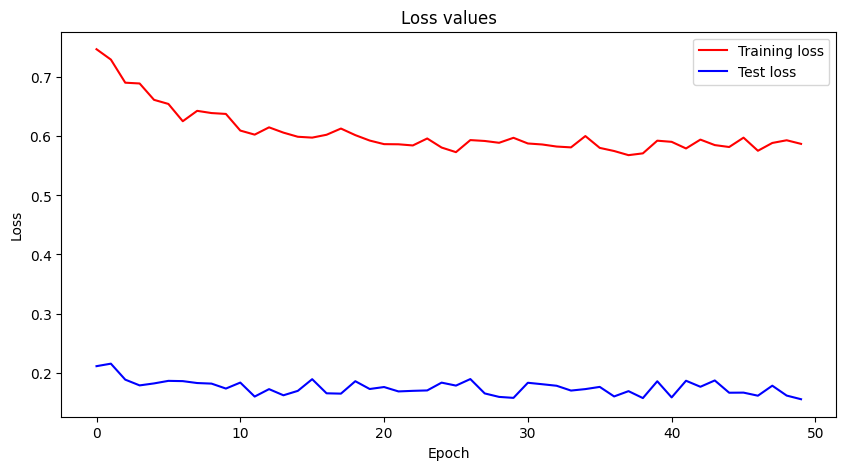

In [8]:
# Hyperparameters
max_nodes = 300
input_dim = 8
gnn_hidden_dim = 32
rnn_hidden_dim = 64
fc_hidden_dim = 48
output_dim = 6
heads = 1
num_gcn_layers = 1
num_gat_layers = 0 
num_rnn_layers = 1
learning_rate = 0.001
num_epochs = 50
batch_size = 128
lambda_reg = 1
lambda_class = 1
# Model and optimizer
model = GraphSequenceNN(input_dim, 
                        gnn_hidden_dim, 
                        rnn_hidden_dim, 
                        fc_hidden_dim, 
                        output_dim,
                        num_gcn_layers,
                        num_gat_layers, 
                        num_rnn_layers, heads)
# Initialize optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)
# Initialize scheduler
scheduler = ExponentialLR(optimizer, gamma=0.95)
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
# Initialize empty lists to store loss values
train_loss_values = []
test_loss_values = []
def evaluate_model(model, test_input_folder, batch_size, max_nodes, device):
    model.eval()
    total_loss = 0
    test_batch_generator = load_sequence_data(test_input_folder, batch_size)
    with torch.no_grad():
        for test_batch in test_batch_generator:
            test_data = prepare_batch(test_batch, max_nodes)
            x_seq, edge_index_seq, x_last, edge_index_last, y, batch_last, seq_lengths = [t.to(device) for t in test_data]
            output = model((x_seq, edge_index_seq, x_last, edge_index_last, batch_last, seq_lengths))
            loss, _, _ = improved_loss_function(output, y, lambda_reg=lambda_reg, lambda_class=lambda_class)
            total_loss += loss.item()
    return total_loss
# Training and evaluation loop
for epoch in range(num_epochs):
    # Training
    model.train()
    total_train_loss = 0
    batch_generator = load_sequence_data(train_input_folder, batch_size)
    for batch in batch_generator:
        data = prepare_batch(batch, max_nodes)
        x_seq, edge_index_seq, x_last, edge_index_last, y, batch_last, seq_lengths = [t.to(device) for t in data]
        optimizer.zero_grad()
        output = model((x_seq, edge_index_seq, x_last, edge_index_last, batch_last, seq_lengths))
        loss, reg_loss, class_loss = improved_loss_function(output, y, lambda_reg=lambda_reg, lambda_class=lambda_class)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    # Evaluation on test data
    total_test_loss = evaluate_model(model, test_input_folder, batch_size, max_nodes, device)

    # Append the losses of this epoch to the lists
    train_loss_values.append(total_train_loss)
    test_loss_values.append(total_test_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {total_train_loss:.4f}, Test Loss: {total_test_loss:.4f}")
    scheduler.step()
# Plot the loss values
plt.figure(figsize=(10,5))
plt.plot(train_loss_values, 'r', label='Training loss')
plt.plot(test_loss_values, 'b', label='Test loss')
plt.legend()
plt.title('Loss values')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
# Save the model
torch.save(model.state_dict(), 'model.pth')

In [9]:
def plot_predictions_and_actual(G, predictions, actual, filename):
    # Create a combined dictionary with x and y coordinates
    pos = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}

    # Separate nodes by type
    map_nodes = [node for node, data in G.nodes(data=True) if data['type'] == 'map_node']

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 8))

    # Draw map nodes
    nx.draw_networkx_nodes(G, pos, nodelist=map_nodes, node_color='lightgray', node_size=2, ax=ax)

    # Draw edges
    nx.draw_networkx_edges(G, pos, edge_color='lightgray', ax=ax)

    # Plot actual dynamic objects
    actual_dynamic_objects = [node for node, data in G.nodes(data=True) if actual[node][0] == 1]
    print(f"Number of actual dynamic objects: {len(actual_dynamic_objects)}")
    #Dyna_pos = {node: (node[1], node[2]) for node in actual_dynamic_objects}
    #nx.draw_networkx_nodes(G, Dyna_pos, nodelist=actual_dynamic_objects, node_color='blue', node_size=50, alpha=0.7, label='Actual Dynamic Objects', ax=ax)

    # Plot predicted dynamic objects
    predicted_dynamic_objects = [node for node, data in G.nodes(data=True) if predictions[node][0] >= 0.85]
    print(f"Number of predicted dynamic objects: {len(predicted_dynamic_objects)}")
    #nx.draw_networkx_nodes(G, pos, nodelist=predicted_dynamic_objects, node_color='red', node_size=50, alpha=0.7, label='Predicted Dynamic Objects', ax=ax)

    # Plot actual traffic lights
    actual_traffic_lights = [node for node, data in G.nodes(data=True) if actual[node][5] == 1]
    print(f"Number of actual traffic lights: {len(actual_traffic_lights)}")
    nx.draw_networkx_nodes(G, pos, nodelist=actual_traffic_lights, node_color='green', node_size=50, alpha=0.7, label='Actual Traffic Lights', ax=ax)

    # Plot predicted traffic lights
    predicted_traffic_lights = [node for node, data in G.nodes(data=True) if predictions[node][5] >= 0.85]
    print(f"Number of predicted traffic lights: {len(predicted_traffic_lights)}")
    nx.draw_networkx_nodes(G, pos, nodelist=predicted_traffic_lights, node_color='orange', node_size=50, alpha=0.7, label='Predicted Traffic Lights', ax=ax)

    # Set axis limits to fit the data
    x_values, y_values = zip(*pos.values())
    padding = 0
    ax.set_xlim(min(x_values) - padding, max(x_values) + padding)
    ax.set_ylim(min(y_values) - padding, max(y_values) + padding)

    # Add a legend
    plt.legend(loc='upper right')

    # Save the figure
    plt.savefig(filename)
    plt.close()

In [10]:
# Final evaluation on test data
model.eval()
with torch.no_grad():
    test_batch_generator = load_sequence_data(test_input_folder, batch_size)
    for i, test_batch in enumerate(test_batch_generator):
        test_data = prepare_batch(test_batch, max_nodes)
        x_seq, edge_index_seq, x_last, edge_index_last, y, batch_last, seq_lengths = [t.to(device) for t in test_data]
        predictions = model((x_seq, edge_index_seq, x_last, edge_index_last, batch_last, seq_lengths))
        
        # Move tensors to CPU before converting to numpy
        predictions = predictions.cpu()
        y = y.cpu()
        batch_last = batch_last.cpu()
        
        # Convert predictions and actual values to numpy for easier handling
        predictions = predictions.numpy()
        y = y.numpy()
        batch_last = batch_last.numpy()
        
        # For each graph in the batch
        for j, G in enumerate(test_batch[-1]):  # We're interested in the last graph of each sequence
            # Get the number of nodes in this graph
            num_nodes = G.number_of_nodes()
            
            # Extract predictions and actual values for this graph
            graph_predictions = predictions[batch_last == j]
            graph_actual = y[batch_last == j]
            
            # Create dictionaries mapping node IDs to their predictions and actual values
            pred_dict = {node: graph_predictions[i] for i, node in enumerate(G.nodes())}
            actual_dict = {node: graph_actual[i] for i, node in enumerate(G.nodes())}
            
            # Plot and save the graph
            plot_predictions_and_actual(G, pred_dict, actual_dict, f'plots/graph_prediction_{i}_{j}.png')

        print(f"Processed batch {i}, graphs visualized and saved.")

print("Evaluation and visualization complete.")

Number of actual dynamic objects: 2
Number of predicted dynamic objects: 0
Number of actual traffic lights: 12
Number of predicted traffic lights: 123
Number of actual dynamic objects: 3
Number of predicted dynamic objects: 0
Number of actual traffic lights: 64
Number of predicted traffic lights: 164
Number of actual dynamic objects: 1
Number of predicted dynamic objects: 0
Number of actual traffic lights: 65
Number of predicted traffic lights: 164
Number of actual dynamic objects: 2
Number of predicted dynamic objects: 0
Number of actual traffic lights: 12
Number of predicted traffic lights: 123
Processed batch 0, graphs visualized and saved.
Number of actual dynamic objects: 1
Number of predicted dynamic objects: 0
Number of actual traffic lights: 6
Number of predicted traffic lights: 115
Number of actual dynamic objects: 1
Number of predicted dynamic objects: 0
Number of actual traffic lights: 12
Number of predicted traffic lights: 123
Number of actual dynamic objects: 1
Number of p